In [1]:
from CoPhaser import utils
from CoPhaser import plotting

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys

sys.path.append("../set_up/")
import plot_helpers
import anndata

import pickle

In [2]:
#reload
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "data/"
SCRNASEQ_DATA_FOLDER = "../../../data/"
data_battich = pickle.load(open(DATA_FOLDER + "battich_results.pkl", "rb"))

height_ratios_scaling: [1, 1, 1, 1]


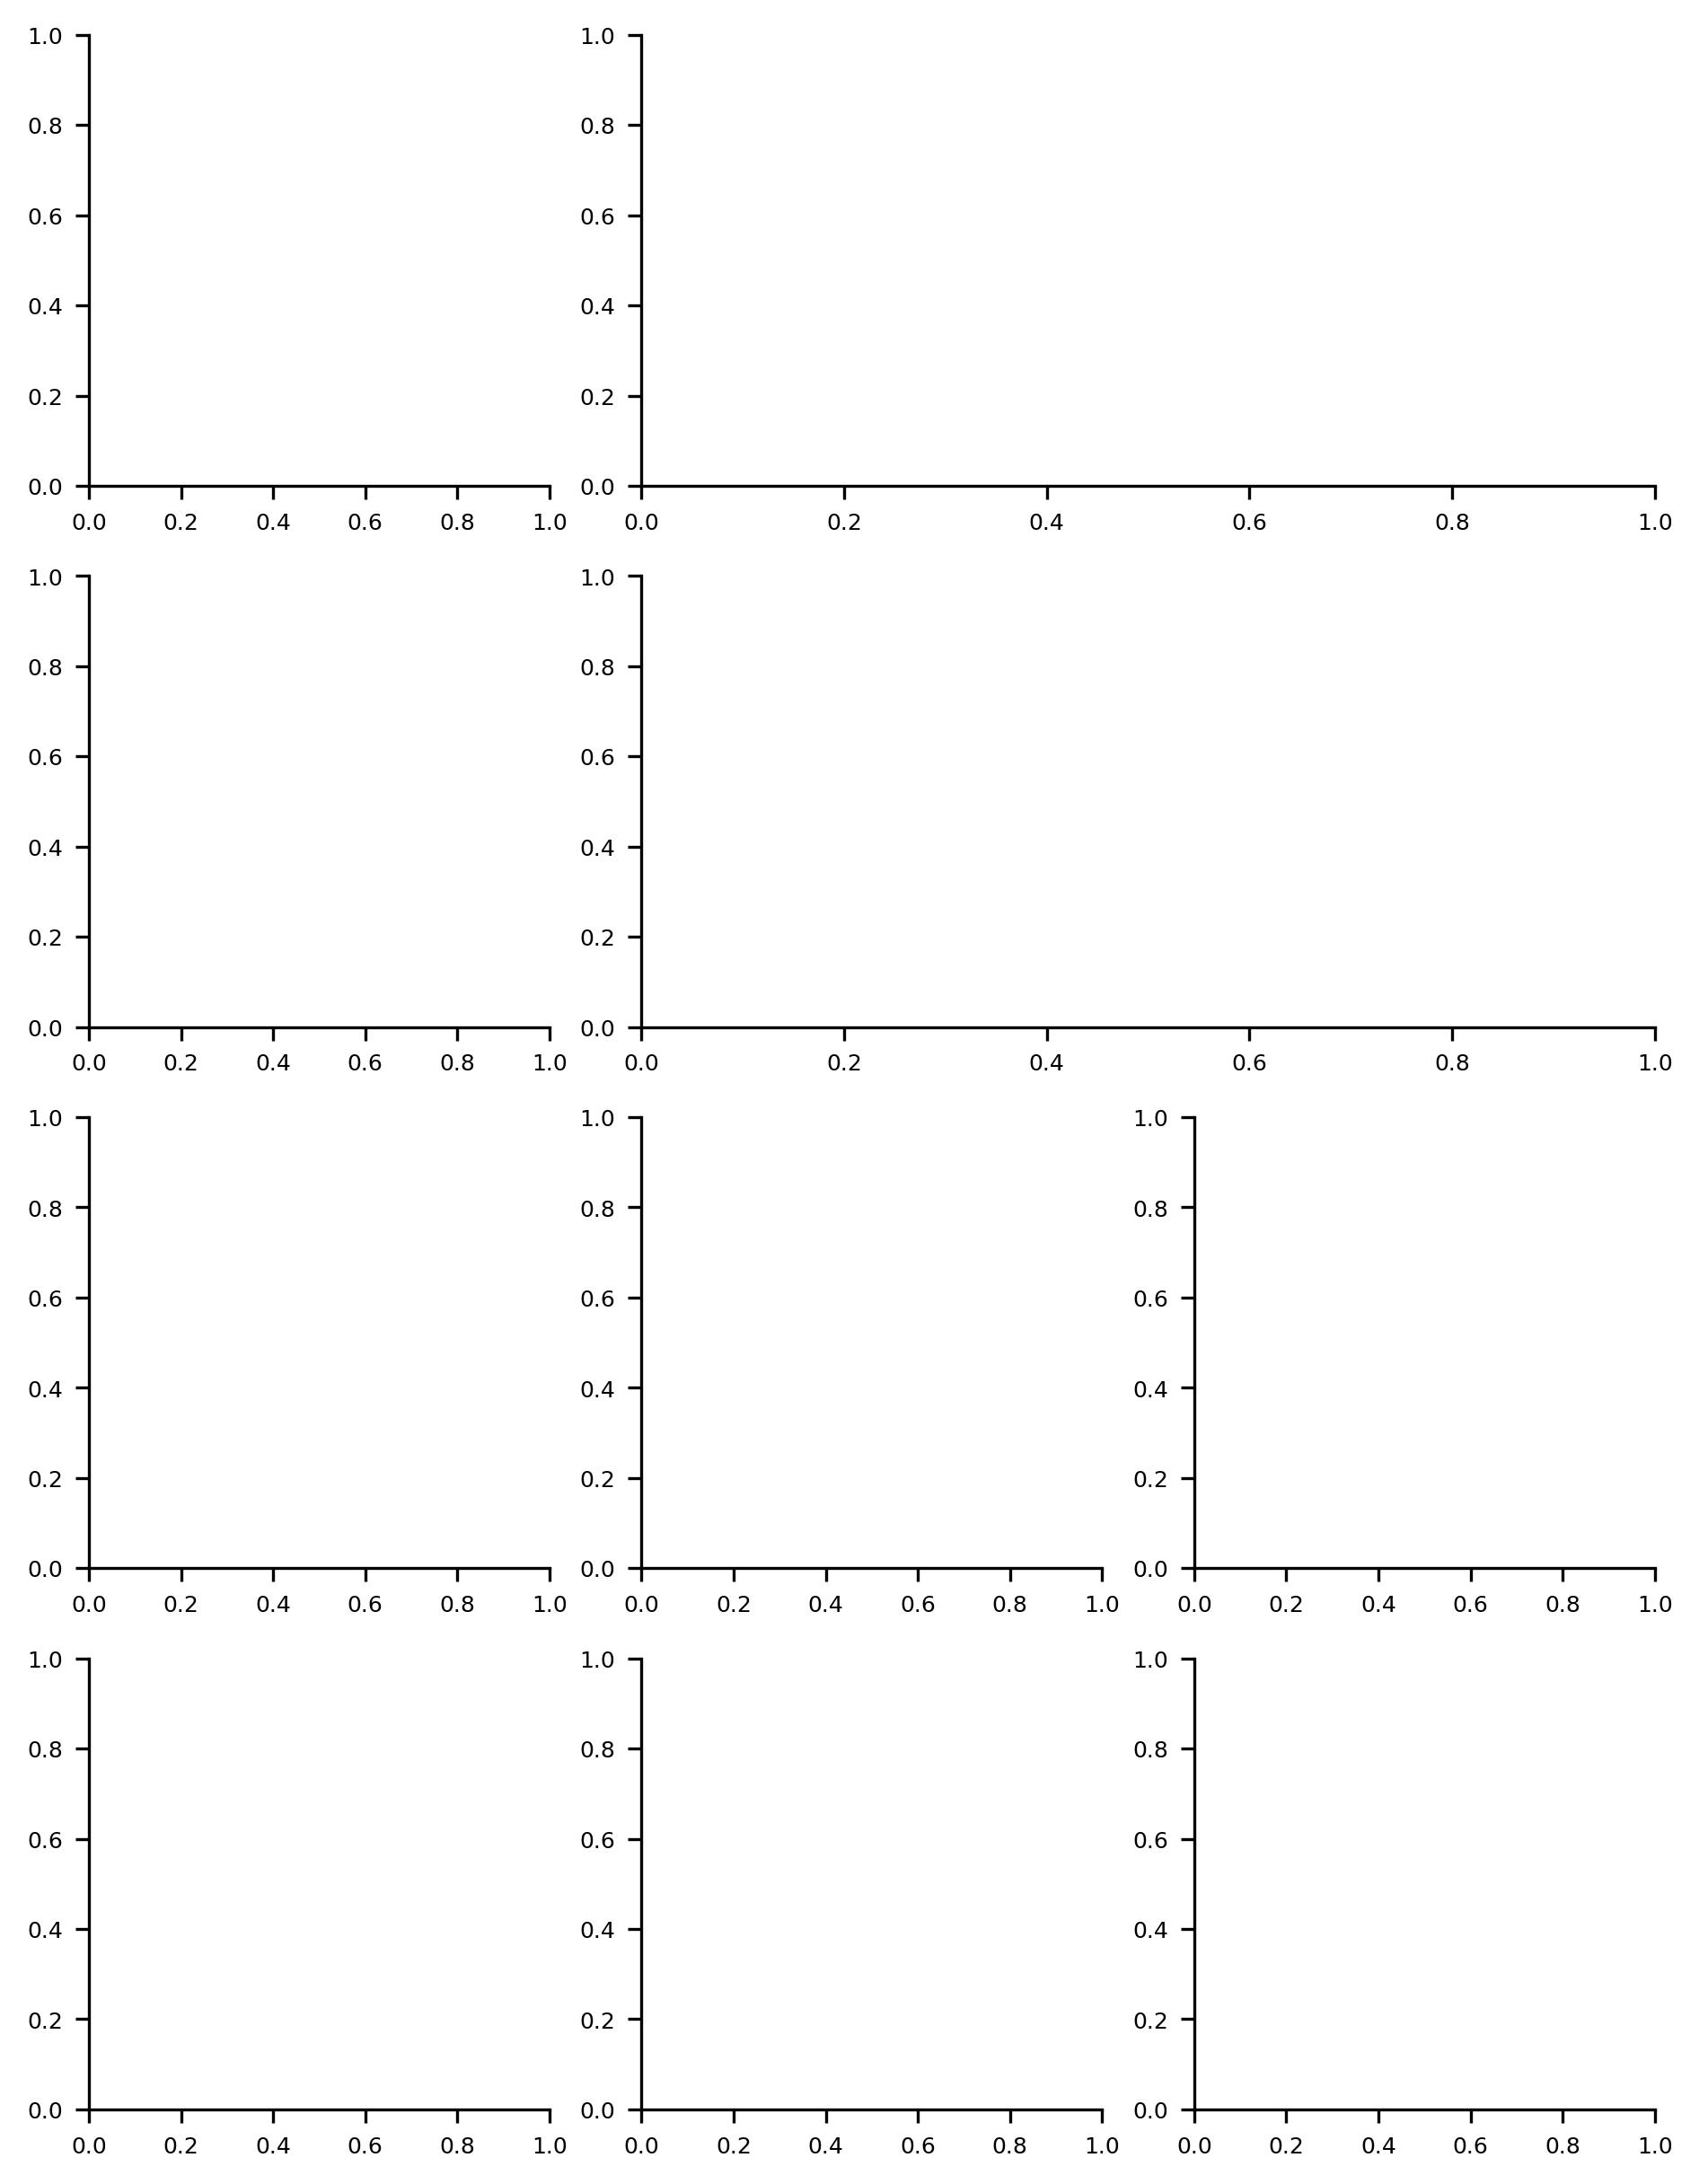

In [4]:
fig, axs = plot_helpers.create_pannels(
    mosaic=[["A", "B", "B"], ["C", "D", "D"], ["E", "F", "G"], ["H", "I", "J"]],
    h_pad=0,
)

In [5]:
fucci_phase = data_battich["df_rhythmic"]["theta_fucci"]
inferred_phase = data_battich["df_rhythmic"]["inferred_theta"]
best_shift = utils.get_best_shift_direction(inferred_phase, fucci_phase)
fucci_phase = utils.normalize_angles(
    fucci_phase * best_shift["direction"] - best_shift["shift"]
)
pca_phase = data_battich["df_rhythmic"]["pca_theta"]
plotting.plot_phase_accuracy(
    fucci_phase,
    inferred_phase,
    title_gt="FUCCI Phase",
    title_pred="Inferred Phase",
    title="Phases Comparison",
    ax=axs["A"],
)

In [8]:
adata_battich = anndata.read_h5ad(
    f"{SCRNASEQ_DATA_FOLDER}battich/Battich_RPE1_labeled.loom"
)
adata_battich.var_names = adata_battich.var.Symbol
adata_battich = adata_battich[data_battich["cells_indices"], :]
library_size = adata_battich.layers["spliced"].sum(axis=1)

In [9]:
TOP2A_fractions = (
    adata_battich[:, "TOP2A"].layers["spliced"].toarray().flatten() / library_size
)

In [10]:
MCM6_fractions = (
    adata_battich[:, "MCM6"].layers["spliced"].toarray().flatten() / library_size
)

In [11]:
PCNA_fractions = (
    adata_battich[:, "PCNA"].layers["spliced"].toarray().flatten() / library_size
)

In [12]:
plot_smoothed_profiles = plotting.plot_smoothed_profiles


def get_gene_fractions(gene_name, adata, layer="spliced"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    fucci_phase=None,
    layer="spliced",
    hue=None,
):
    axs = plot_helpers.replace_mosaic_cell_with_grid(
        fig, axs, label=position, nrows=1, ncols=len(gene_names)
    )
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        _, axs[position][i] = plotting.modify_axis_labels(
            ax=axs[position][i], axis="x", step=0.5
        )
        plot_smoothed_profiles(
            inferred_phase,
            np.log2(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel="Inferred Phase",
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            label=(
                "Inferred"
                if (i == len(gene_names) - 1 and fucci_phase is not None)
                else None
            ),
            legend=i == len(gene_names) - 1,
            hue=hue,
        )
        if fucci_phase is not None:
            plot_smoothed_profiles(
                utils.normalize_angles(fucci_phase - 1.5),
                np.log2(gene_fractions * 1e4 + 1),
                ax=axs[position][i],
                nbins=20,
                xlabel="Phase",
                ylabel=f"Normalized Counts (log)" if i == 0 else None,
                label="FUCCI" if i == len(gene_names) - 1 else None,
            )
        # set title in italic and bold
        axs[position][i].set_title(
            f"{gene_name}", fontstyle="italic", fontweight="bold"
        )


plot_gene_profiles(
    ["MCM6", "PCNA", "TOP2A"],
    adata_battich,
    inferred_phase,
    axs,
    position="B",
    fucci_phase=fucci_phase,
    layer="spliced",
)

RPE

In [15]:
data_RPE = pickle.load(open(DATA_FOLDER + "rpe_results.pkl", "rb"))
adata_RPE = anndata.read_h5ad(
    f"{SCRNASEQ_DATA_FOLDER}cellcycle_maxine/RPE_37C_Rep1_full.h5ad"
)
adata_RPE = anndata.concat(
    [
        adata_RPE,
        anndata.read_h5ad(
            f"{SCRNASEQ_DATA_FOLDER}cellcycle_maxine/RPE_37C_Rep2_full.h5ad"
        ),
    ]
)
adata_RPE.obs_names_make_unique()
adata_RPE = adata_RPE[data_RPE["cell_indices"], :]

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
library_size = data_RPE["library_size"]

In [17]:
adata_RPE.obs["batch"] = (
    (pd.factorize(adata_RPE.obs["batch"])[0] + 1).astype("str").copy()
)

/tmp/ipykernel_329774/3115089976.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RPE.obs["batch"] = (


In [18]:
adata_RPE.obs["batch"].unique()

array(['1', '2'], dtype=object)

In [19]:
adata_RPE.obs["Batch"] = adata_RPE.obs["batch"]

In [20]:
ax = axs["C"]
sns.scatterplot(
    x=data_RPE["z_space"]["z_1"],
    y=data_RPE["z_space"]["z_2"],
    hue=adata_RPE.obs["Batch"],
    ax=ax,
    s=10,
    edgecolor=None,
)
ax.set_title("z Space")
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("z1")
ax.set_ylabel("z2")

Text(86.99999999999999, 0.5, 'z2')

In [21]:
gene_fractions = get_gene_fractions("MCM6", adata_RPE, layer="spliced")

In [22]:
gene_fractions.shape

(15237,)

In [23]:
library_size = adata_RPE.layers["spliced"].sum(axis=1)
library_size = np.array(library_size).flatten()

In [24]:
plot_gene_profiles(
    ["MCM6", "PCNA", "TOP2A"],
    adata_RPE,
    utils.normalize_angles(data_RPE["inferred_theta"] - 0.5),
    axs,
    position="D",
    layer="spliced",
    hue=adata_RPE.obs["Batch"],
)

In [27]:
axs = plot_helpers.make_polar(axs, "E")
plotting.plot_cell_cycle(data_RPE["df_rhythmic"], ax=axs["E"])

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


In [28]:
ax = axs["F"]
plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)[0]
plot_smoothed_profiles(
    data_RPE["inferred_theta"],
    library_size,
    ax=axs["F"],
    nbins=20,
    xlabel="Inferred Phase",
    ylabel="Mean #UMI",
    title="#UMI vs Inferred Phase",
    hue=adata_RPE.obs["Batch"],
)

In [30]:
ax = axs["G"]
plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)[0]
plot_smoothed_profiles(
    data_RPE["inferred_theta"],
    get_gene_fractions("HIST1H4C", adata_RPE, layer="spliced"),
    ax=ax,
    xlabel="Inferred Phase",
    ylabel="Normalized Counts",
    hue=adata_RPE.obs["Batch"],
)
ax.set_title("H4C3", fontstyle="italic", fontweight="bold")
ax.set_ylim(bottom=0)

(0.0, 0.010165769226112691)

VASA

In [ ]:
data_VASA = pickle.load(open(DATA_FOLDER + "vasa_res.pkl", "rb"))

{'embedding': array([[-1.7479428, 11.770438 ],
        [12.535977 , 11.360967 ],
        [ 2.099037 , 12.784089 ],
        ...,
        [ 3.0999982, 14.994775 ],
        [ 9.211832 ,  2.7688165],
        [12.046578 , 11.078278 ]], dtype=float32),
 'phases': 0        1.353041
 1        2.813054
 2        2.478801
 3       -3.133023
 4        2.018315
            ...   
 46117   -0.826039
 46118    1.380422
 46120   -0.822513
 46121    0.450558
 46123   -2.350754
 Name: inferred_theta, Length: 38913, dtype: float32,
 'author_labels': 0          NaN
 1          NaN
 2         True
 3          NaN
 4         True
          ...  
 46117    False
 46118     True
 46120    False
 46121      NaN
 46123     True
 Name: S-phase, Length: 38913, dtype: object,
 'JS_res': {'Our Method': [0.8359352851362121],
  'UMAP': [0.473721231194144],
  'Cyclop': [0.12634239067230416],
  'Velo\nCycle': [0.07434213701886656],
  'random': 0.03631005697217307,
  'Tricycle': [0.1515010546695972],
  'PCA': [0.444775

In [33]:
ax = axs["H"]
sns.scatterplot(
    x=data_VASA["f_space"][:, 0],
    y=data_VASA["f_space"][:, 1],
    hue=data_VASA["author_labels"],
    alpha=0.1,  # keep points transparent
    edgecolor=None,
    s=1,
    ax=ax,
)

# Make legend markers fully opaque
leg = ax.get_legend()
if leg is not None:
    for lh in leg.legend_handles:
        lh.set_alpha(1)

ax.set_title("f Space")
ax.set_yticks([])
ax.set_xticks([])

[]

In [35]:
ax = axs["I"]
sns.scatterplot(
    x=data_VASA["embedding"][:, 0],
    y=data_VASA["embedding"][:, 1],
    hue=data_VASA["cell_types"],
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
    legend=False,
)
ax.set_title("z Space")
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend(title="Celltypes")

/tmp/ipykernel_329774/897595513.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Celltypes")


In [37]:
js_divergence = pd.DataFrame(data_VASA["JS_res"])
js_divergence.drop("UMAP", inplace=True, axis=1)
js_divergence.drop("Velo\nCycle", inplace=True, axis=1)
js_divergence = js_divergence[
    sorted(
        js_divergence.columns, key=lambda col: js_divergence.loc[0, col], reverse=True
    )
]
js_divergence.rename(columns={"Cyclop": "Cyclum"}, inplace=True)

In [38]:
columns = js_divergence.columns.to_numpy()
for i in range(1, len(columns), 2):
    columns[i] = "\n" + columns[i]
js_divergence.columns = columns

In [39]:
ax = axs["J"]
sns.barplot(data=js_divergence, ax=ax)
# rotate labels
ax.set_title("S-phase Accuracy")
ax.set_ylabel("JS Distance")

Text(1317.8823529411764, 0.5, 'JS Distance')

/home/maxine/Documents/paychere/CoPhaser/paper/code/figure_2/../set_up/plot_helpers.py:91: UserWarning: Rasterization of 'Line2D(_child1)' will be ignored
  artist.set_rasterized(True)


Figure saved to: /home/maxine/Documents/paychere/CoPhaser/paper/figures/figure_2_python.svg


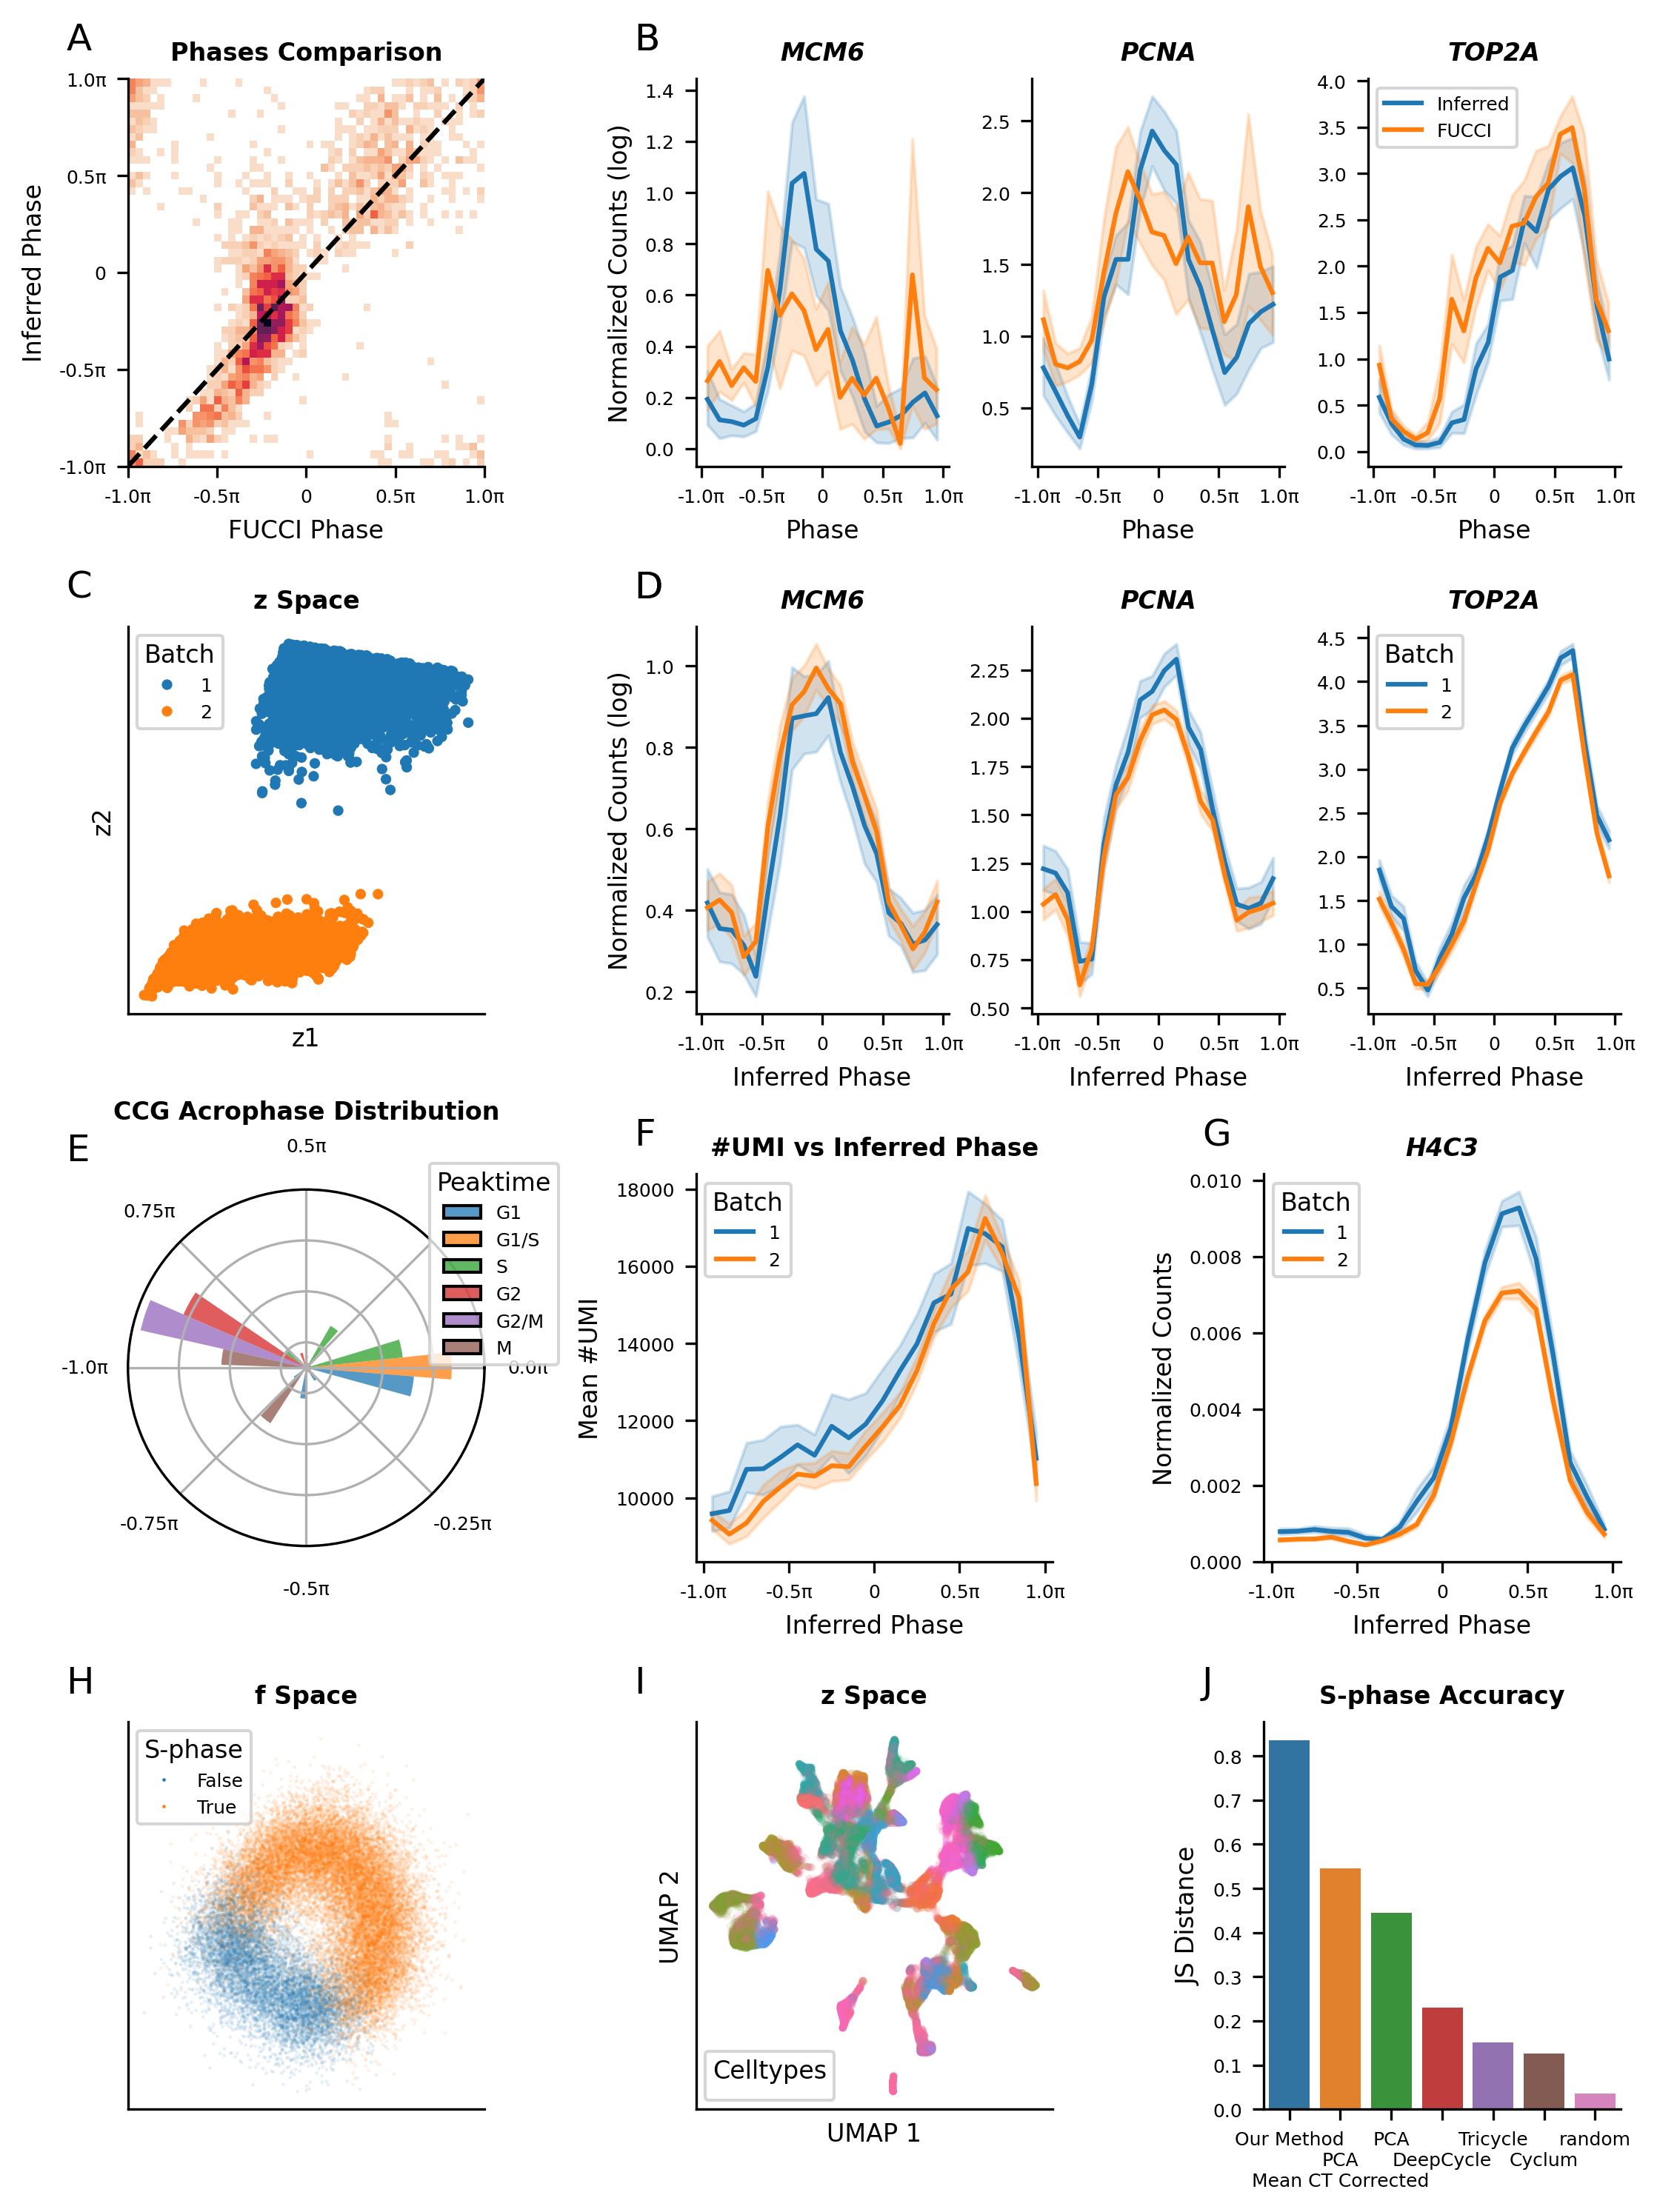

In [40]:
plot_helpers.label_panels_mosaic(
    fig,
    axs,
    mosaic=[["A", "B", "B"], ["C", "D", "D"], ["E", "F", "G"], ["H", "I", "J"]],
)
plot_helpers.save_figure(fig, axs, "figure_2_python")